# 04 - Supervised Learning (Classification)

This notebook includes:
- Target variable definition pass/fail
- Feature engineering and encoding
- Multiple classification algorithms
- Hyperparameter tuning
- Cross-validation
- Model interpretation

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings

warnings.filterwarnings("ignore")

In [55]:
df = pd.read_pickle(r"../data/processed/cleaned_dataset.pkl")
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Dalc,Walc,health,absences,G1,G2,G3,pass_fail,attendance_proxy,grade_average
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,1,1,3,4,0,11,11,1,87.50,7.333333
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,1,1,3,2,9,11,11,1,93.75,10.333333
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,2,3,3,6,12,13,12,1,81.25,12.333333
3,GP,F,15,U,GT3,T,4,2,health,services,...,1,1,5,0,14,14,14,1,100.00,14.000000
4,GP,F,16,U,GT3,T,3,3,other,other,...,1,2,5,0,11,13,13,1,100.00,12.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,1,2,5,4,10,11,10,1,87.50,10.333333
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,1,1,1,4,15,15,16,1,87.50,15.333333
646,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,5,6,11,12,9,0,81.25,10.666667
647,MS,M,17,U,LE3,T,3,1,services,services,...,3,4,2,6,10,10,10,1,81.25,10.000000


In [56]:
# Handle different data types properly after preprocessing

# Apply encoding
df_encoded = df.copy()

# 1. ORDINAL VARIABLES - Convert ordered categoricals to numeric (preserve order)
ordinal_vars = [
    "Medu",
    "Fedu",
    "traveltime",
    "studytime",
    "famrel",
    "freetime",
    "goout",
    "Dalc",
    "Walc",
    "health",
]
for var in ordinal_vars:
    if var in df_encoded.columns:
        df_encoded[var] = df_encoded[
            var
        ].cat.codes  # Converts to 0,1,2,3,4 maintaining order
        print(f"Ordinal encoded {var}")

# 2. BINARY VARIABLES - Convert booleans to 0/1
binary_vars = [
    "schoolsup",
    "famsup",
    "paid",
    "activities",
    "nursery",
    "higher",
    "internet",
    "romantic",
]
for var in binary_vars:
    if var in df_encoded.columns:
        df_encoded[var] = df_encoded[var].astype(int)  # True->1, False->0
        print(f"Boolean to binary: {var}")

# 3. NOMINAL CATEGORICALS - Binary mapping for 2-level, one-hot for multi-level
# Binary mappings for 2-level categoricals
binary_mappings = {
    "school": {"GP": 1, "MS": 0},
    "sex": {"F": 1, "M": 0},
    "address": {"U": 1, "R": 0},
    "famsize": {"GT3": 1, "LE3": 0},
    "Pstatus": {"T": 1, "A": 0},
}

# Apply binary encoding
for col, mapping in binary_mappings.items():
    if col in df_encoded.columns:
        df_encoded[col] = df_encoded[col].map(mapping)
        print(f"Binary encoded {col}")

# Multi-level categorical columns for one-hot encoding
categorical_cols = ["Mjob", "Fjob", "reason", "guardian"]

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)
print(f"One-hot encoded: {categorical_cols}")
print(f"New shape after encoding: {df_encoded.shape}")

# 4. NUMERIC VARIABLES already handled (age, failures, absences, G1, G2, G3)

# Remove target leakage
features_to_drop = ["G3"]
X = df_encoded.drop(columns=features_to_drop + ["pass_fail"])
y = df_encoded["pass_fail"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Results
print(f"\nFinal results:")
print(f"Training shape: {X_train_scaled.shape}")
print(f"Test shape: {X_test_scaled.shape}")
print(f"Pass rate - Train: {y_train.mean():.1%}, Test: {y_test.mean():.1%}")
print(f"All features are now numeric and scaled.")

Ordinal encoded Medu
Ordinal encoded Fedu
Ordinal encoded traveltime
Ordinal encoded studytime
Ordinal encoded famrel
Ordinal encoded freetime
Ordinal encoded goout
Ordinal encoded Dalc
Ordinal encoded Walc
Ordinal encoded health
Boolean to binary: schoolsup
Boolean to binary: famsup
Boolean to binary: paid
Boolean to binary: activities
Boolean to binary: nursery
Boolean to binary: higher
Boolean to binary: internet
Boolean to binary: romantic
Binary encoded school
Binary encoded sex
Binary encoded address
Binary encoded famsize
Binary encoded Pstatus
One-hot encoded: ['Mjob', 'Fjob', 'reason', 'guardian']
New shape after encoding: (649, 45)

Final results:
Training shape: (519, 43)
Test shape: (130, 43)
Pass rate - Train: 84.6%, Test: 84.6%
All features are now numeric and scaled.


In [57]:
# Create two feature sets from the scaled data
print("Available features:", X.columns.tolist())

# Set 1: Keep all current features (includes G1, G2)
X_with_grades = X.copy()
X_train_with_grades = X_train_scaled.copy()
X_test_with_grades = X_test_scaled.copy()

# Set 2: Remove G1 and G2 from the scaled data
grade_columns = ["G1", "G2"]
grade_indices = [X.columns.get_loc(col) for col in grade_columns if col in X.columns]

X_without_grades = X.drop(columns=grade_columns)
X_train_without_grades = np.delete(X_train_scaled, grade_indices, axis=1)
X_test_without_grades = np.delete(X_test_scaled, grade_indices, axis=1)

# Results
print(f"\nFeature sets created:")
print(
    f"WITH G1, G2 - Train: {X_train_with_grades.shape}, Test: {X_test_with_grades.shape}"
)
print(
    f"WITHOUT G1, G2 - Train: {X_train_without_grades.shape}, Test: {X_test_without_grades.shape}"
)
print(f"Features removed: {grade_columns}")

Available features: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'attendance_proxy', 'grade_average', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_mother', 'guardian_other']

Feature sets created:
WITH G1, G2 - Train: (519, 43), Test: (130, 43)
WITHOUT G1, G2 - Train: (519, 41), Test: (130, 41)
Features removed: ['G1', 'G2']


# Function-Based Model Implementation

## Logistic Regression

In [77]:
def logistic_regression_base(X_train, X_test, title):
    """Base Logistic Regression Model"""
    print(f"LOGISTIC REGRESSION MODEL {title.upper()}")

    # Initialize and train the model
    log_reg = LogisticRegression(random_state=42)
    log_reg.fit(X_train, y_train)

    # Make predictions on TEST data
    y_pred_lr = log_reg.predict(X_test)

    # Evaluate the model
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_lr))

    # Logistic Regression metrics
    lr_accuracy = accuracy_score(y_test, y_pred_lr)
    lr_precision = precision_score(y_test, y_pred_lr)
    lr_recall = recall_score(y_test, y_pred_lr)
    lr_f1 = f1_score(y_test, y_pred_lr)

    # Confusion Matrix
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred_lr)
    plt.figure(figsize=(8, 6))
    lr_color = "#0d47a1"
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=sns.light_palette(lr_color, as_cmap=True),
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Logistic Regression - {title}")
    plt.show()

    return lr_accuracy, lr_precision, lr_recall, lr_f1


def logistic_regression_tuned(X_train, X_test, title):
    """Hyperparameter Tuned Logistic Regression Model"""
    print(f"HYPERPARAMETER TUNED LOGISTIC REGRESSION MODEL {title.upper()}")

    # Define the parameter grid
    param_grid = {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "penalty": ["l1", "l2"],
        "solver": ["liblinear", "saga"],
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        LogisticRegression(random_state=42, max_iter=1000),
        param_grid,
        cv=5,
        scoring="f1",
        n_jobs=-1,
    )

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_log_reg = grid_search.best_estimator_

    # Print the best parameters
    print("Best Hyperparameters for Logistic Regression:")
    print(grid_search.best_params_)

    # Make predictions with the improved model
    y_pred_lr = best_log_reg.predict(X_test)

    # Evaluate the improved model
    print("\nClassification Report for Improved Logistic Regression:")
    print(classification_report(y_test, y_pred_lr))

    # Tuned Logistic Regression metrics
    lr_tuned_accuracy = accuracy_score(y_test, y_pred_lr)
    lr_tuned_precision = precision_score(y_test, y_pred_lr)
    lr_tuned_recall = recall_score(y_test, y_pred_lr)
    lr_tuned_f1 = f1_score(y_test, y_pred_lr)

    # Confusion Matrix for the improved model
    print("\nConfusion Matrix for Improved Model:")
    cm_improved = confusion_matrix(y_test, y_pred_lr)
    plt.figure(figsize=(8, 6))
    lr_tuned_color = "#42a5f5"
    sns.heatmap(
        cm_improved,
        annot=True,
        fmt="d",
        cmap=sns.light_palette(lr_tuned_color, as_cmap=True),
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Tuned Logistic Regression - {title}")
    plt.show()

    return lr_tuned_accuracy, lr_tuned_precision, lr_tuned_recall, lr_tuned_f1

## Random Forest

In [78]:
def random_forest_base(X_train, X_test, title):
    """Base Random Forest Model"""
    print(f"RANDOM FOREST MODEL {title.upper()}")

    # Initialize and train the model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred_rf = rf.predict(X_test)

    # Evaluate the model
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_rf))

    # Random Forest metrics
    rf_accuracy = accuracy_score(y_test, y_pred_rf)
    rf_precision = precision_score(y_test, y_pred_rf)
    rf_recall = recall_score(y_test, y_pred_rf)
    rf_f1 = f1_score(y_test, y_pred_rf)

    # Confusion Matrix
    print("Confusion Matrix:")
    cm_rf = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(8, 6))
    rf_color = "#1b5e20"
    sns.heatmap(
        cm_rf,
        annot=True,
        fmt="d",
        cmap=sns.light_palette(rf_color, as_cmap=True),
    )
    plt.title(f"Random Forest - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return rf_accuracy, rf_precision, rf_recall, rf_f1


def random_forest_tuned(X_train, X_test, title):
    """Hyperparameter Tuned Random Forest Model"""
    print(f"HYPERPARAMETER TUNED RANDOM FOREST MODEL {title.upper()}")

    # Define the parameter distribution for Randomized Search
    param_dist = {
        "n_estimators": [100, 200, 300],
        "max_depth": [10, 20, 30, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
    }

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        RandomForestClassifier(random_state=42),
        param_distributions=param_dist,
        n_iter=20,  # Try 20 different combinations
        cv=5,
        scoring="f1",
        n_jobs=-1,
        random_state=42,
    )

    random_search.fit(X_train, y_train)

    # Get the best model
    best_rf = random_search.best_estimator_

    print("Best Hyperparameters for Random Forest:")
    print(random_search.best_params_)

    # Make predictions with the tuned model
    y_pred_rf = best_rf.predict(X_test)

    # Evaluate the tuned model
    print("\nClassification Report for Tuned Random Forest:")
    print(classification_report(y_test, y_pred_rf))

    # Tuned Random Forest metrics
    rf_tuned_accuracy = accuracy_score(y_test, y_pred_rf)
    rf_tuned_precision = precision_score(y_test, y_pred_rf)
    rf_tuned_recall = recall_score(y_test, y_pred_rf)
    rf_tuned_f1 = f1_score(y_test, y_pred_rf)

    # Confusion Matrix for the tuned model
    print("\nConfusion Matrix for Tuned Model:")
    cm_rf_tuned = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(8, 6))
    rf_tuned_color = "#66bb6a"
    sns.heatmap(
        cm_rf_tuned,
        annot=True,
        fmt="d",
        cmap=sns.light_palette(rf_tuned_color, as_cmap=True),
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Tuned Random Forest - {title}")
    plt.show()

    return rf_tuned_accuracy, rf_tuned_precision, rf_tuned_recall, rf_tuned_f1

## Gradient Boosting Machine

In [79]:
def gradient_boosting_base(X_train, X_test, title):
    """Base Gradient Boosting Model"""
    print(f"GRADIENT BOOSTING MODEL {title.upper()}")

    gbm = GradientBoostingClassifier(random_state=42)
    gbm.fit(X_train, y_train)

    y_pred_gbm = gbm.predict(X_test)

    # Evaluate the model
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_gbm))

    # Gradient Boosting metrics
    gbm_accuracy = accuracy_score(y_test, y_pred_gbm)
    gbm_precision = precision_score(y_test, y_pred_gbm)
    gbm_recall = recall_score(y_test, y_pred_gbm)
    gbm_f1 = f1_score(y_test, y_pred_gbm)

    # Confusion Matrix
    print("Confusion Matrix:")
    cm_gbm = confusion_matrix(y_test, y_pred_gbm)
    plt.figure(figsize=(8, 6))
    gbm_color = "#4a148c"
    sns.heatmap(
        cm_gbm,
        annot=True,
        fmt="d",
        cmap=sns.light_palette(gbm_color, as_cmap=True),
    )
    plt.title(f"Gradient Boosting - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return gbm_accuracy, gbm_precision, gbm_recall, gbm_f1


def gradient_boosting_tuned(X_train, X_test, title):
    """Hyperparameter Tuned Gradient Boosting Model"""
    print(f"TUNED GRADIENT BOOSTING MODEL {title.upper()}")

    # Define the parameter distribution for Randomized Search for GBM
    param_dist_gbm = {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "subsample": [0.8, 0.9, 1.0],
    }

    # Initialize RandomizedSearchCV for GBM
    random_search_gbm = RandomizedSearchCV(
        GradientBoostingClassifier(random_state=42),
        param_distributions=param_dist_gbm,
        n_iter=20,  # Try 20 different combinations
        cv=5,
        scoring="f1",
        n_jobs=-1,
        random_state=42,
    )

    # Fit the random search to the data
    random_search_gbm.fit(X_train, y_train)

    # Get the best model
    best_gbm = random_search_gbm.best_estimator_

    # Print the best parameters
    print("Best Hyperparameters for Gradient Boosting:")
    print(random_search_gbm.best_params_)

    # Make predictions with the tuned model
    y_pred_gbm = best_gbm.predict(X_test)

    # Evaluate the tuned model
    print("\nClassification Report for Tuned Gradient Boosting:")
    print(classification_report(y_test, y_pred_gbm))

    # Tuned Gradient Boosting metrics
    gbm_tuned_accuracy = accuracy_score(y_test, y_pred_gbm)
    gbm_tuned_precision = precision_score(y_test, y_pred_gbm)
    gbm_tuned_recall = recall_score(y_test, y_pred_gbm)
    gbm_tuned_f1 = f1_score(y_test, y_pred_gbm)

    # Confusion Matrix for the tuned model
    print("\nConfusion Matrix for Tuned GBM:")
    cm_gbm_tuned = confusion_matrix(y_test, y_pred_gbm)
    plt.figure(figsize=(8, 6))
    gbm_tuned_color = "#9575cd"
    sns.heatmap(
        cm_gbm_tuned,
        annot=True,
        fmt="d",
        cmap=sns.light_palette(gbm_tuned_color, as_cmap=True),
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Tuned Gradient Boosting - {title}")
    plt.show()

    return gbm_tuned_accuracy, gbm_tuned_precision, gbm_tuned_recall, gbm_tuned_f1

## Model Execution and Comparison

MODELS WITH G1 & G2 FEATURES
LOGISTIC REGRESSION MODEL WITH G1 & G2

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        20
           1       0.94      0.96      0.95       110

    accuracy                           0.92       130
   macro avg       0.85      0.81      0.83       130
weighted avg       0.91      0.92      0.91       130

Confusion Matrix:


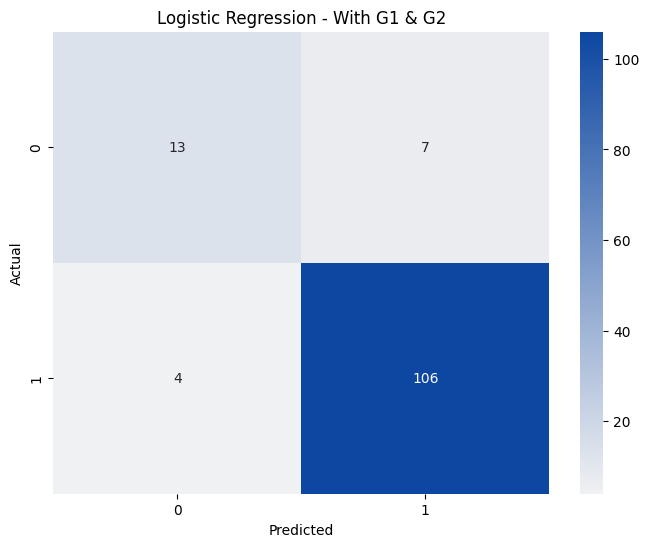

__________________________________________________
HYPERPARAMETER TUNED LOGISTIC REGRESSION MODEL WITH G1 & G2
Best Hyperparameters for Logistic Regression:
{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}

Classification Report for Improved Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        20
           1       0.97      1.00      0.99       110

    accuracy                           0.98       130
   macro avg       0.99      0.93      0.95       130
weighted avg       0.98      0.98      0.98       130


Confusion Matrix for Improved Model:


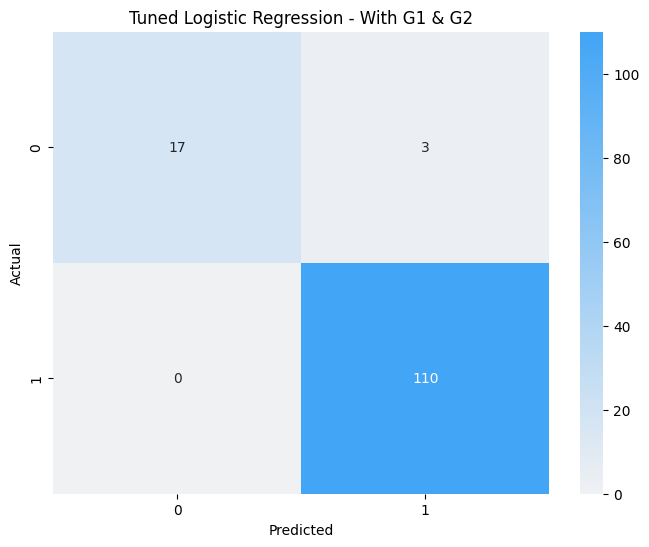

__________________________________________________
RANDOM FOREST MODEL WITH G1 & G2

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        20
           1       0.94      0.96      0.95       110

    accuracy                           0.92       130
   macro avg       0.85      0.81      0.83       130
weighted avg       0.91      0.92      0.91       130

Confusion Matrix:


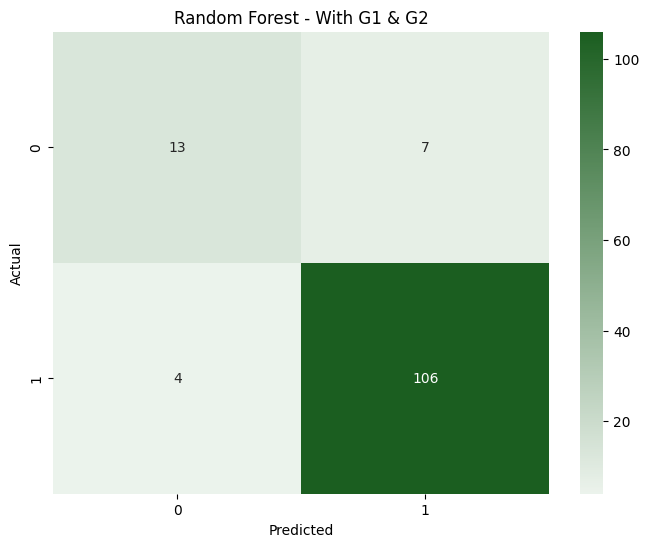

__________________________________________________
HYPERPARAMETER TUNED RANDOM FOREST MODEL WITH G1 & G2
Best Hyperparameters for Random Forest:
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': False}

Classification Report for Tuned Random Forest:
              precision    recall  f1-score   support

           0       0.81      0.65      0.72        20
           1       0.94      0.97      0.96       110

    accuracy                           0.92       130
   macro avg       0.88      0.81      0.84       130
weighted avg       0.92      0.92      0.92       130


Confusion Matrix for Tuned Model:


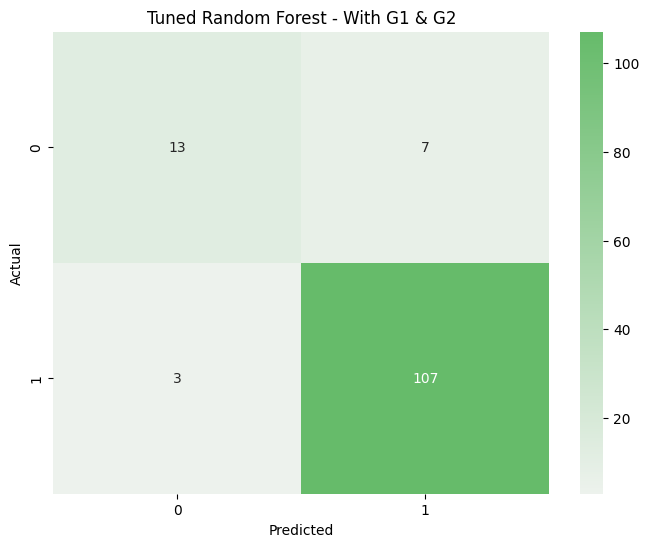

__________________________________________________
GRADIENT BOOSTING MODEL WITH G1 & G2

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.70      0.80        20
           1       0.95      0.99      0.97       110

    accuracy                           0.95       130
   macro avg       0.94      0.85      0.88       130
weighted avg       0.95      0.95      0.94       130

Confusion Matrix:


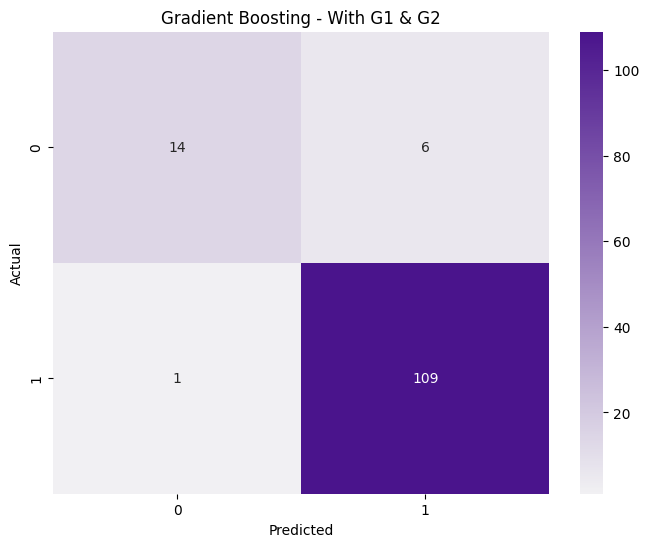

__________________________________________________
TUNED GRADIENT BOOSTING MODEL WITH G1 & G2
Best Hyperparameters for Gradient Boosting:
{'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.1}

Classification Report for Tuned Gradient Boosting:
              precision    recall  f1-score   support

           0       0.94      0.80      0.86        20
           1       0.96      0.99      0.98       110

    accuracy                           0.96       130
   macro avg       0.95      0.90      0.92       130
weighted avg       0.96      0.96      0.96       130


Confusion Matrix for Tuned GBM:


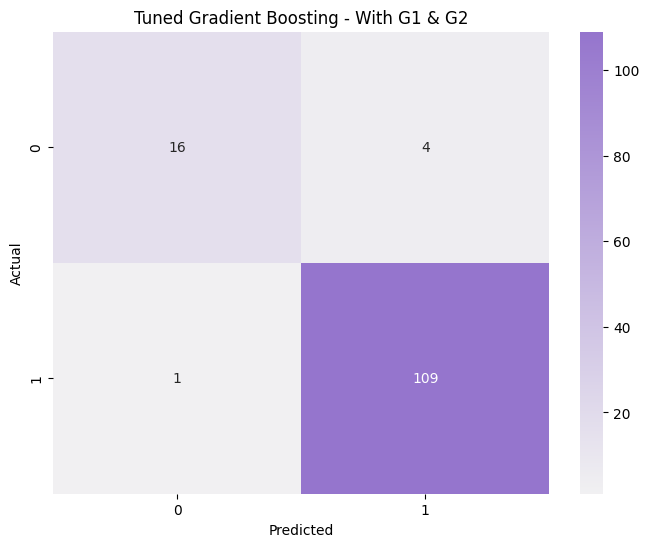

In [80]:
# Initialize results dictionary for comparison
results = {}

# Run all models WITH G1 & G2
print("=" * 60)
print("MODELS WITH G1 & G2 FEATURES")
print("=" * 60)

# Logistic Regression - Base & Tuned
lr_base_acc, lr_base_prec, lr_base_rec, lr_base_f1 = logistic_regression_base(
    X_train_with_grades, X_test_with_grades, "With G1 & G2"
)
print("_" * 50)

lr_tuned_acc, lr_tuned_prec, lr_tuned_rec, lr_tuned_f1 = logistic_regression_tuned(
    X_train_with_grades, X_test_with_grades, "With G1 & G2"
)
print("_" * 50)

# Random Forest - Base & Tuned
rf_base_acc, rf_base_prec, rf_base_rec, rf_base_f1 = random_forest_base(
    X_train_with_grades, X_test_with_grades, "With G1 & G2"
)
print("_" * 50)

rf_tuned_acc, rf_tuned_prec, rf_tuned_rec, rf_tuned_f1 = random_forest_tuned(
    X_train_with_grades, X_test_with_grades, "With G1 & G2"
)
print("_" * 50)

# Gradient Boosting - Base & Tuned
gbm_base_acc, gbm_base_prec, gbm_base_rec, gbm_base_f1 = gradient_boosting_base(
    X_train_with_grades, X_test_with_grades, "With G1 & G2"
)
print("_" * 50)

gbm_tuned_acc, gbm_tuned_prec, gbm_tuned_rec, gbm_tuned_f1 = gradient_boosting_tuned(
    X_train_with_grades, X_test_with_grades, "With G1 & G2"
)

# Store results WITH grades
results["with_grades"] = {
    "LR_Base": [lr_base_acc, lr_base_prec, lr_base_rec, lr_base_f1],
    "LR_Tuned": [lr_tuned_acc, lr_tuned_prec, lr_tuned_rec, lr_tuned_f1],
    "RF_Base": [rf_base_acc, rf_base_prec, rf_base_rec, rf_base_f1],
    "RF_Tuned": [rf_tuned_acc, rf_tuned_prec, rf_tuned_rec, rf_tuned_f1],
    "GBM_Base": [gbm_base_acc, gbm_base_prec, gbm_base_rec, gbm_base_f1],
    "GBM_Tuned": [gbm_tuned_acc, gbm_tuned_prec, gbm_tuned_rec, gbm_tuned_f1],
}


MODELS WITHOUT G1 & G2 FEATURES
LOGISTIC REGRESSION MODEL WITHOUT G1 & G2

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.55      0.67        20
           1       0.92      0.98      0.95       110

    accuracy                           0.92       130
   macro avg       0.88      0.77      0.81       130
weighted avg       0.91      0.92      0.91       130

Confusion Matrix:


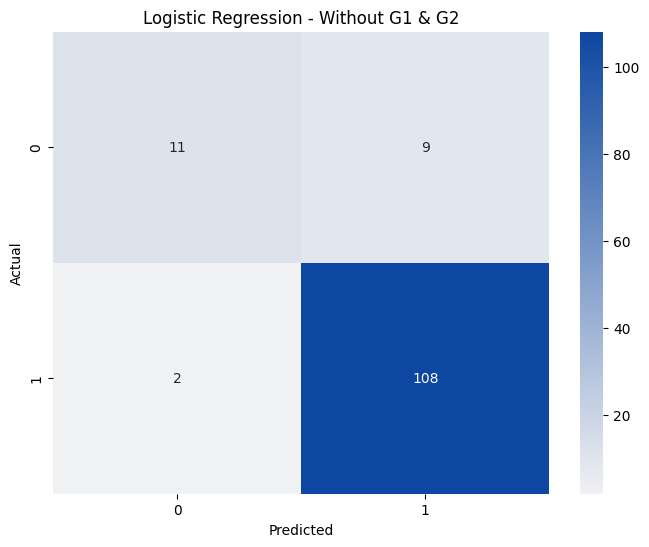

__________________________________________________
HYPERPARAMETER TUNED LOGISTIC REGRESSION MODEL WITHOUT G1 & G2
Best Hyperparameters for Logistic Regression:
{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

Classification Report for Improved Logistic Regression:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79        20
           1       0.96      0.97      0.96       110

    accuracy                           0.94       130
   macro avg       0.89      0.86      0.88       130
weighted avg       0.94      0.94      0.94       130


Confusion Matrix for Improved Model:


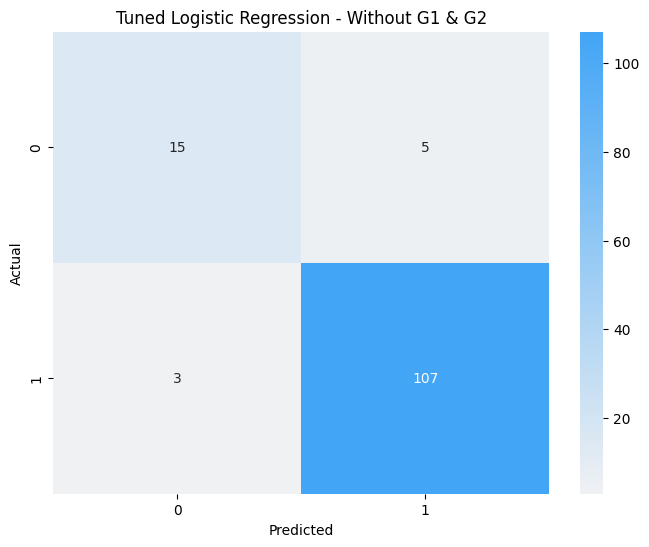

__________________________________________________
RANDOM FOREST MODEL WITHOUT G1 & G2

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.65      0.74        20
           1       0.94      0.98      0.96       110

    accuracy                           0.93       130
   macro avg       0.90      0.82      0.85       130
weighted avg       0.93      0.93      0.93       130

Confusion Matrix:


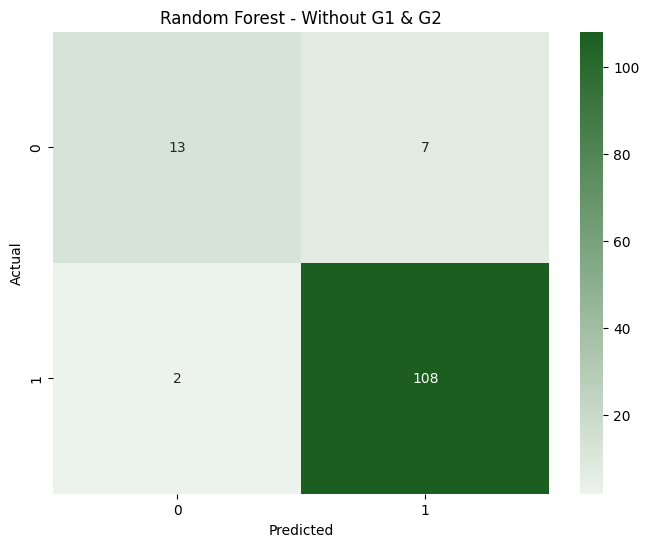

__________________________________________________
HYPERPARAMETER TUNED RANDOM FOREST MODEL WITHOUT G1 & G2
Best Hyperparameters for Random Forest:
{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': None, 'bootstrap': False}

Classification Report for Tuned Random Forest:
              precision    recall  f1-score   support

           0       0.81      0.65      0.72        20
           1       0.94      0.97      0.96       110

    accuracy                           0.92       130
   macro avg       0.88      0.81      0.84       130
weighted avg       0.92      0.92      0.92       130


Confusion Matrix for Tuned Model:


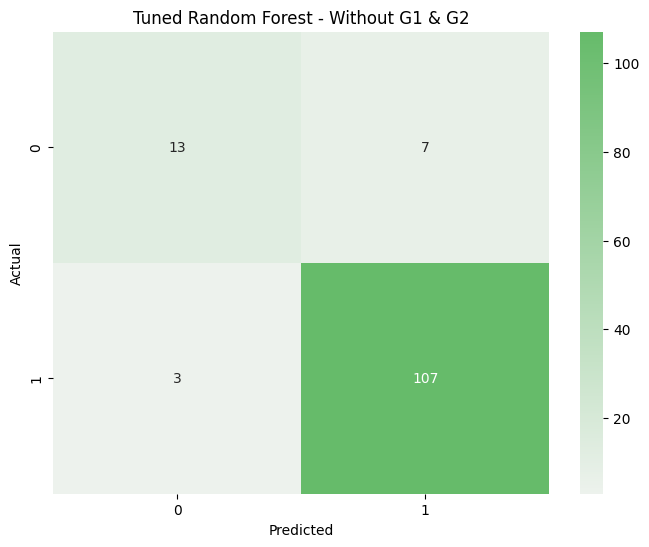

__________________________________________________
GRADIENT BOOSTING MODEL WITHOUT G1 & G2

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.70      0.76        20
           1       0.95      0.97      0.96       110

    accuracy                           0.93       130
   macro avg       0.89      0.84      0.86       130
weighted avg       0.93      0.93      0.93       130

Confusion Matrix:


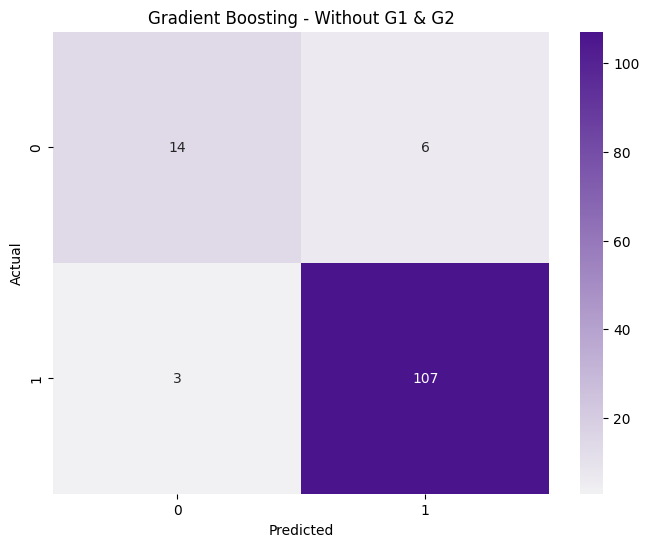

__________________________________________________
TUNED GRADIENT BOOSTING MODEL WITHOUT G1 & G2
Best Hyperparameters for Gradient Boosting:
{'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.01}

Classification Report for Tuned Gradient Boosting:
              precision    recall  f1-score   support

           0       0.81      0.65      0.72        20
           1       0.94      0.97      0.96       110

    accuracy                           0.92       130
   macro avg       0.88      0.81      0.84       130
weighted avg       0.92      0.92      0.92       130


Confusion Matrix for Tuned GBM:


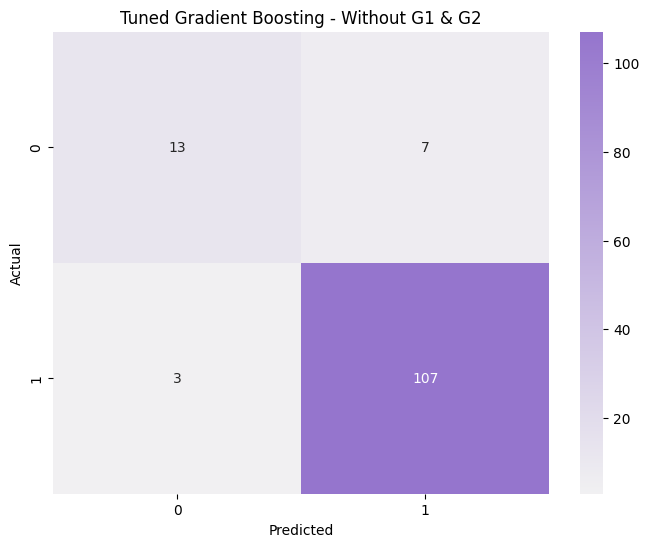

In [81]:
# Run all models WITHOUT G1 & G2
print("\n" + "=" * 60)
print("MODELS WITHOUT G1 & G2 FEATURES")
print("=" * 60)

# Logistic Regression - Base & Tuned
lr_base_acc_no, lr_base_prec_no, lr_base_rec_no, lr_base_f1_no = (
    logistic_regression_base(
        X_train_without_grades, X_test_without_grades, "Without G1 & G2"
    )
)
print("_" * 50)

lr_tuned_acc_no, lr_tuned_prec_no, lr_tuned_rec_no, lr_tuned_f1_no = (
    logistic_regression_tuned(
        X_train_without_grades, X_test_without_grades, "Without G1 & G2"
    )
)
print("_" * 50)

# Random Forest - Base & Tuned
rf_base_acc_no, rf_base_prec_no, rf_base_rec_no, rf_base_f1_no = random_forest_base(
    X_train_without_grades, X_test_without_grades, "Without G1 & G2"
)
print("_" * 50)

rf_tuned_acc_no, rf_tuned_prec_no, rf_tuned_rec_no, rf_tuned_f1_no = (
    random_forest_tuned(
        X_train_without_grades, X_test_without_grades, "Without G1 & G2"
    )
)
print("_" * 50)

# Gradient Boosting - Base & Tuned
gbm_base_acc_no, gbm_base_prec_no, gbm_base_rec_no, gbm_base_f1_no = (
    gradient_boosting_base(
        X_train_without_grades, X_test_without_grades, "Without G1 & G2"
    )
)
print("_" * 50)

gbm_tuned_acc_no, gbm_tuned_prec_no, gbm_tuned_rec_no, gbm_tuned_f1_no = (
    gradient_boosting_tuned(
        X_train_without_grades, X_test_without_grades, "Without G1 & G2"
    )
)

# Store results WITHOUT grades
results["without_grades"] = {
    "LR_Base": [lr_base_acc_no, lr_base_prec_no, lr_base_rec_no, lr_base_f1_no],
    "LR_Tuned": [lr_tuned_acc_no, lr_tuned_prec_no, lr_tuned_rec_no, lr_tuned_f1_no],
    "RF_Base": [rf_base_acc_no, rf_base_prec_no, rf_base_rec_no, rf_base_f1_no],
    "RF_Tuned": [rf_tuned_acc_no, rf_tuned_prec_no, rf_tuned_rec_no, rf_tuned_f1_no],
    "GBM_Base": [gbm_base_acc_no, gbm_base_prec_no, gbm_base_rec_no, gbm_base_f1_no],
    "GBM_Tuned": [
        gbm_tuned_acc_no,
        gbm_tuned_prec_no,
        gbm_tuned_rec_no,
        gbm_tuned_f1_no,
    ],
}


COMPREHENSIVE MODEL COMPARISON
Full Model Comparison Table:
           Accuracy_WITH_GRADES  Precision_WITH_GRADES  Recall_WITH_GRADES  \
LR_Base                  0.9154                 0.9381              0.9636   
LR_Tuned                 0.9769                 0.9735              1.0000   
RF_Base                  0.9154                 0.9381              0.9636   
RF_Tuned                 0.9231                 0.9386              0.9727   
GBM_Base                 0.9462                 0.9478              0.9909   
GBM_Tuned                0.9615                 0.9646              0.9909   

           F1-Score_WITH_GRADES  Accuracy_WITHOUT_GRADES  \
LR_Base                  0.9507                   0.9154   
LR_Tuned                 0.9865                   0.9385   
RF_Base                  0.9507                   0.9308   
RF_Tuned                 0.9554                   0.9231   
GBM_Base                 0.9689                   0.9308   
GBM_Tuned                0.9776 

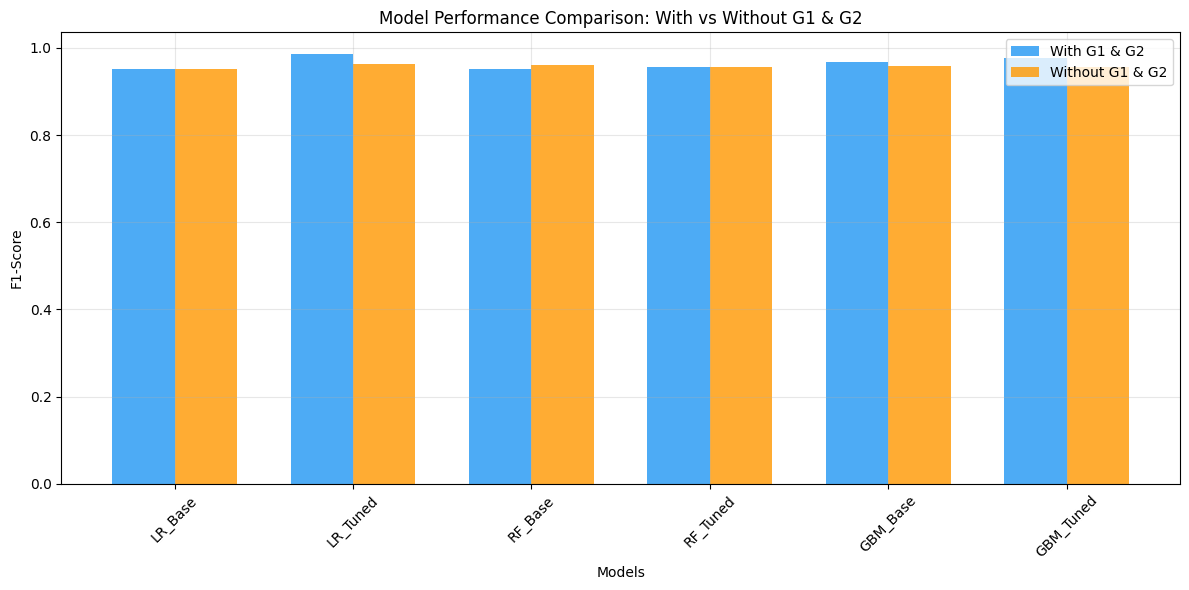


Best Performing Models:
WITH G1 & G2: LR_Tuned (F1: 0.9865)
WITHOUT G1 & G2: LR_Tuned (F1: 0.9640)

Improvement from including G1 & G2:
LR_Base: +-0.0009 (-0.1% improvement)
LR_Tuned: +0.0226 (2.3% improvement)
RF_Base: +-0.0093 (-1.0% improvement)
RF_Tuned: +0.0000 (0.0% improvement)
GBM_Base: +0.0092 (1.0% improvement)
GBM_Tuned: +0.0222 (2.3% improvement)


In [82]:
# Create comprehensive comparison DataFrame
print("\n" + "=" * 80)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 80)

# Create comparison dataframes
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

# WITH G1 & G2 DataFrame
df_with_grades = pd.DataFrame(results["with_grades"], index=metrics).T
df_with_grades.columns = [f"{col}_WITH_GRADES" for col in df_with_grades.columns]

# WITHOUT G1 & G2 DataFrame
df_without_grades = pd.DataFrame(results["without_grades"], index=metrics).T
df_without_grades.columns = [
    f"{col}_WITHOUT_GRADES" for col in df_without_grades.columns
]

# Combine both dataframes
comparison_df = pd.concat([df_with_grades, df_without_grades], axis=1)

# Round to 4 decimal places for better readability
comparison_df = comparison_df.round(4)

print("Full Model Comparison Table:")
print(comparison_df)

# Create a focused comparison (F1-Score only)
f1_comparison = pd.DataFrame(
    {
        "With G1 & G2": [
            results["with_grades"][model][3] for model in results["with_grades"].keys()
        ],
        "Without G1 & G2": [
            results["without_grades"][model][3]
            for model in results["without_grades"].keys()
        ],
    },
    index=list(results["with_grades"].keys()),
)

print("\nF1-Score Comparison:")
print(f1_comparison.round(4))

# Visualize F1-Score comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(f1_comparison.index))
width = 0.35

plt.bar(
    x - width / 2,
    f1_comparison["With G1 & G2"],
    width,
    label="With G1 & G2",
    alpha=0.8,
    color="#2196f3",
)
plt.bar(
    x + width / 2,
    f1_comparison["Without G1 & G2"],
    width,
    label="Without G1 & G2",
    alpha=0.8,
    color="#ff9800",
)

plt.xlabel("Models")
plt.ylabel("F1-Score")
plt.title("Model Performance Comparison: With vs Without G1 & G2")
plt.xticks(x, f1_comparison.index, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find best performing models
print("\nBest Performing Models:")
print(
    f"WITH G1 & G2: {f1_comparison['With G1 & G2'].idxmax()} "
    f"(F1: {f1_comparison['With G1 & G2'].max():.4f})"
)
print(
    f"WITHOUT G1 & G2: {f1_comparison['Without G1 & G2'].idxmax()} "
    f"(F1: {f1_comparison['Without G1 & G2'].max():.4f})"
)

# Calculate improvement from G1 & G2
print("\nImprovement from including G1 & G2:")
improvements = f1_comparison["With G1 & G2"] - f1_comparison["Without G1 & G2"]
for model in improvements.index:
    improvement = improvements[model]
    pct_improvement = (improvement / f1_comparison.loc[model, "Without G1 & G2"]) * 100
    print(f"{model}: +{improvement:.4f} ({pct_improvement:.1f}% improvement)")